## Fastext своими руками

ПЕРЕДЕЛАННАЯ ТЕТРАДКА

In [ ]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Torch version:", torch.__version__)

Using device: cuda
Torch version: 2.9.0+cu126


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# в нашем корпусе 20к текстов
wiki = open('/content/drive/MyDrive/Colab Notebooks/wiki_data.txt').read().split('\n')

In [ ]:
import re
from collections import Counter
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


Второй базовый элемент - это нграммер, чтобы разбивать токен на символьные нграммы
Обратите внимание что к токену добавляются <> чтобы учесть в нграммах, что они стоят в начале или в конце

In [ ]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

Следующая функция проходится по токенам и разбивает каждый токен на подсимвольные нграммы в заданном интервале

In [ ]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords


Теперь нам нужно спаппить токены и подсимвольные нграммы в индексы и для этого нужно построить словарь. Это немного сложнее чем раньше потому что мы хотим иметь в словаре и полные слова и символьные нграммы, но нам нужно иметь отдельный список только полных слов, чтобы потом иметь возможность находить ближайшие слова.

Чтобы было удобнее со всеми переменными напишем класс для токенизации

In [ ]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text)
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))


In [ ]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [ ]:
tokenizer.build_vocab(wiki)

In [ ]:
import numpy as np

def pad_sequences(sequences, maxlen, padding='post', value=0):
    """
    sequences: list of lists (разной длины)
    возвращает np.array shape (len(sequences), maxlen)
    """
    res = np.full((len(sequences), maxlen), value, dtype='int64')
    for i, seq in enumerate(sequences):
        if not seq:
            continue
        if len(seq) >= maxlen:
            if padding == 'post':
                res[i] = np.array(seq[:maxlen])
            else:
                res[i] = np.array(seq[-maxlen:])
        else:
            if padding == 'post':
                res[i, :len(seq)] = np.array(seq)
            else:
                res[i, -len(seq):] = np.array(seq)
    return res


In [ ]:
def gen_batches_ft(sentences, tokenizer, window=5, batch_size=1000, maxlen=20):

    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            sent_encoded = tokenizer(sent)  # список [ [full, sub1, sub2...], ... ]
            for i in range(len(sent_encoded)-1):
                word_with_subtokens = sent_encoded[i]
                context = sent_encoded[max(0, i-left_context_length):i] + sent_encoded[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    X_target.append(word_with_subtokens)
                    X_context.append(context_word_with_subtokens)
                    y.append(1)

                    neg_id = np.random.randint(1, vocab_size)
                    X_target.append([neg_id])
                    X_context.append(context_word_with_subtokens)
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target_arr = pad_sequences(X_target, maxlen=maxlen, padding='post', value=0)
                        X_context_arr = pad_sequences(X_context, maxlen=window, padding='post', value=0)
                        y_arr = np.array(y, dtype='float32')
                        yield (X_target_arr, X_context_arr), y_arr
                        X_target, X_context, y = [], [], []


In [ ]:
class FastTextSkipGram(nn.Module):
    def __init__(self, vocab_size, emb_dim, window_size=5):
        super().__init__()
        self.target_emb = nn.Embedding(vocab_size, emb_dim)
        self.context_emb = nn.Embedding(vocab_size, emb_dim)
        self.window_size = window_size

    def forward(self, target_subtokens, context_subtokens):

        t_embs = self.target_emb(target_subtokens)
        t_vec = t_embs.sum(dim=1)

        c_embs = self.context_emb(context_subtokens)
        c_vec = c_embs.sum(dim=1)

        dot = (t_vec * c_vec).sum(dim=1)
        return dot

In [ ]:
vocab_size = len(tokenizer.vocab)
emb_dim = 100

model = FastTextSkipGram(vocab_size, emb_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
train_gen = gen_batches_ft(wiki[:19000], tokenizer, window=10, batch_size=100, maxlen=20)
valid_gen = gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100, maxlen=20)

steps_per_epoch = 10000
validation_steps = 100
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for step in range(steps_per_epoch):
        (X_target, X_context), y_batch = next(train_gen)
        X_target = torch.tensor(X_target, dtype=torch.long, device=device)
        X_context = torch.tensor(X_context, dtype=torch.long, device=device)
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)

        optimizer.zero_grad()
        logits = model(X_target, X_context)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= steps_per_epoch
    train_losses.append(epoch_loss)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _ in range(validation_steps):
            (X_target, X_context), y_batch = next(valid_gen)
            X_target = torch.tensor(X_target, dtype=torch.long, device=device)
            X_context = torch.tensor(X_context, dtype=torch.long, device=device)
            y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)

            logits = model(X_target, X_context)
            loss = criterion(logits, y_batch)
            val_loss += loss.item()
    val_loss /= validation_steps
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}")

Epoch 1/10 - train loss: 24.0321, val loss: 24.0610
Epoch 2/10 - train loss: 17.5072, val loss: 11.6711
Epoch 3/10 - train loss: 12.8905, val loss: 12.1390
Epoch 4/10 - train loss: 10.1262, val loss: 7.8972
Epoch 5/10 - train loss: 7.7025, val loss: 8.3311
Epoch 6/10 - train loss: 6.0019, val loss: 5.0864
Epoch 7/10 - train loss: 4.9619, val loss: 5.8929
Epoch 8/10 - train loss: 4.0377, val loss: 4.2028
Epoch 9/10 - train loss: 2.9938, val loss: 3.0735
Epoch 10/10 - train loss: 2.7217, val loss: 2.4875


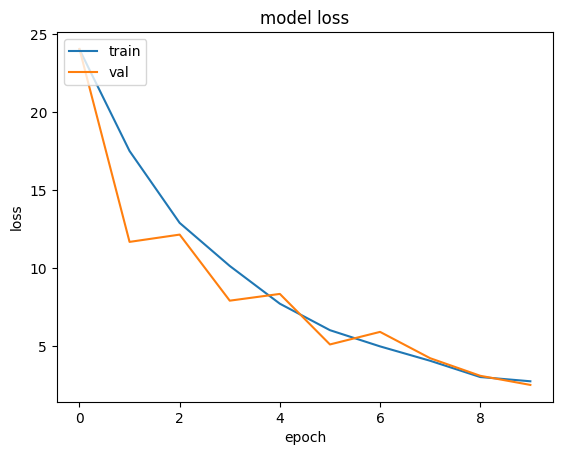

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

Искать похожие немного сложнее так как нам нужно для всех полных слов еще и учесть информацию об их поднграммах.

In [ ]:
embeddings = model.target_emb.weight.detach().cpu().numpy()

In [ ]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0)

In [ ]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

Из результатов поиска видно что fastext учитывает поднграмы и находит как ближайшие не только близкие по смыслу но и по форме

In [ ]:
most_similar_ft('техника', embeddings, tokenizer)

['техника',
 'техникой',
 'техник',
 'технике',
 'техникума',
 'технику',
 'техники',
 'техникуме',
 'хроника',
 'техникум',
 'участника',
 'памятника',
 'волшебника',
 'защитника',
 'охотника',
 'клавишника',
 'спутника',
 'ника',
 'противника',
 'технические']

In [ ]:
most_similar_ft("город", embeddings, tokenizer)

['город',
 '«город',
 'города',
 'пород',
 'городам',
 'ужгород',
 'город»',
 'городе',
 'городища',
 'городище',
 'городке',
 'городом',
 'огород',
 'городской',
 'городах',
 'городу',
 'городок',
 'новгород',
 'городское',
 'городов']

In [ ]:
most_similar_ft("спорт", embeddings, tokenizer)

['спорт',
 'спорта',
 'спорт»',
 'спортом',
 'экспорт',
 'спорту',
 'спорте',
 'лапорт',
 'порт',
 'споре',
 'паспорт',
 'спортивная',
 'спортивной',
 'спорили',
 'спортивное',
 'спортивную',
 'экспорта',
 'спортивном',
 'спортивному',
 'спортивного']